# 第二次作业

本次作业我们将对比不同network embedding算法的效果，包括DeepWalk, NetMF, NetSMF, ProNE。
相关的模型我们可以直接从cogdl中加载，但需要大家选择合适的超参值，并对实验结果进行一些分析。

本作业需要安装[CogDL](https://github.com/THUDM/cogdl)：pip install cogdl

如需使用gpu版，请先安装gpu版本的[PyTorch](https://pytorch.org/get-started/locally/)，再安装cogdl。

本作业由智谱GNN中心及课程团队筹备，由CogDL团队提供技术支持。

## 0. 安装CogDL
如果已安装CogDL，可以忽略这一步

In [1]:
!pip install cogdl

## 1. 加载数据集

本次作业我们使用PPI数据集，是一个蛋白质交互网络。其中每个节点代表一个蛋白质，每条边代表蛋白质之间的交互关系，节点标签代表蛋白质的某种状态。

In [2]:
from cogdl.datasets import build_dataset_from_name

dataset = build_dataset_from_name("ppi-ne")
graph = dataset[0]
print(graph)

labels = graph.y.numpy()

Processing...
Done!
Graph(y=[3890, 50], edge_index=[2, 76584], edge_attr=[1, 76584])


## 2. 模型训练


### 2.1 DeepWalk模型训练

In [2]:
from cogdl.models.emb.deepwalk import DeepWalk

###################
##### 作业填空 #####
###################
'''
请用自己的语言解释以下超参的含义，并为它们选择合适的值填入下面的模型实例化中。
1. walk_length: Length of walk
2. walk_num: each node sample
3. window_size: context size
'''
deepwalk = DeepWalk(dimension=128, walk_length=80, walk_num=40, window_size=5, worker=1, iteration=10)
deepwalk_emb = deepwalk(graph)
print(deepwalk_emb.shape)

  0%|          | 0/10 [00:00<?, ?it/s]

node number: 3890
generating random walks...


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


training word2vec...
(3890, 128)


### 2.2 NetMF模型训练

In [3]:
from cogdl.models.emb.netmf import NetMF

###################
##### 作业填空 #####
###################
'''
请用自己的语言解释以下超参的含义，并为它们选择合适的值填入下面的模型实例化中。
1. window_size: context size
2. rank: laplacian
3. negative: nagative samples nums
4. is_large: big or not
'''
netmf = NetMF(dimension=128, window_size=5, rank=256, negative=1, is_large=True)
netmf_emb = netmf(graph)
print(netmf_emb.shape)

Running NetMF for a small window size...
Compute matrix %d-th power 1
Compute matrix %d-th power 2
Compute matrix %d-th power 3
Compute matrix %d-th power 4
Compute matrix %d-th power 5
(3890, 128)


### 2.3 NetSMF模型训练

In [4]:
from cogdl.models.emb.netsmf import NetSMF

###################
##### 作业填空 #####
###################
'''
请用自己的语言解释以下超参的含义，并为它们选择合适的值填入下面的模型实例化中。
1. window_size: 一样
2. negative: 一样
3. num_round: number of round
'''
netsmf = NetSMF(dimension=128, window_size=10, negative=1, num_round=100, worker=1)
netsmf_emb = netsmf(graph)
print(netsmf_emb.shape)

alias_nodes 0.2021329402923584
number of sample edges  1936950
random walk start...


100%|██████████| 387390/387390 [00:43<00:00, 8877.98it/s]


random walk time 44.221038818359375
construct random walk matrix time 0.0067098140716552734
number of nzz 691205
construct matrix sparsifier time 0.1208808422088623
svd sparse 0.04567806186847827
sparsesvd time 0.6594181060791016
(3890, 128)


### 2.4 ProNE模型训练

In [5]:
from cogdl.models.emb.prone import ProNE

###################
##### 作业填空 #####
###################
'''
请用自己的语言解释以下超参的含义，并为它们选择合适的值填入下面的模型实例化中。
1. step: The number of items in the chebyshev expansion.
2. mu: Parameter
3. theta: Parameter
'''
prone = ProNE(dimension=128, step=5, mu=0.2, theta=.5)
prone_emb = prone(graph)
print(prone_emb.shape)

(3890, 128)


## 3. 训练下游多标签线性分类器得到预测结果

由于PPI数据集是一个多标签（multi-label）的数据集，所以我们需要对每一维标签分别进行预测，然后使用Micro-F1指标作为最后的评估指标。

In [6]:
import numpy as np
import scipy.sparse as sp
from collections import defaultdict

from sklearn.utils import shuffle as skshuffle
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score


class TopKRanker(OneVsRestClassifier):
    def predict(self, X, top_k_list):
        assert X.shape[0] == len(top_k_list)
        probs = np.asarray(super(TopKRanker, self).predict_proba(X))
        all_labels = sp.lil_matrix(probs.shape)

        for i, k in enumerate(top_k_list):
            probs_ = probs[i, :]
            labels = self.classes_[probs_.argsort()[-k:]].tolist()
            for label in labels:
                all_labels[i, label] = 1
        return all_labels

def evaluate(features_matrix, label_matrix, num_shuffle=3, training_percents=[0.1, 0.3, 0.5, 0.7, 0.9]):
    if len(label_matrix.shape) > 1:
        labeled_nodes = np.nonzero(np.sum(label_matrix, axis=1) > 0)[0]
        features_matrix = features_matrix[labeled_nodes]
        label_matrix = label_matrix[labeled_nodes]

    # shuffle, to create train/test groups
    shuffles = []
    for _ in range(num_shuffle):
        shuffles.append(skshuffle(features_matrix, label_matrix))

    # score each train/test group
    all_results = defaultdict(list)

    for train_percent in training_percents:
        for shuf in shuffles:
            X, y = shuf

            training_size = int(train_percent * len(features_matrix))
            X_train = X[:training_size, :]
            y_train = y[:training_size, :]

            X_test = X[training_size:, :]
            y_test = y[training_size:, :]

            clf = TopKRanker(LogisticRegression(solver="liblinear"))
            clf.fit(X_train, y_train)

            # find out how many labels should be predicted
            top_k_list = y_test.sum(axis=1).astype(np.int).tolist()
            preds = clf.predict(X_test, top_k_list)
            result = f1_score(y_test, preds, average="micro")
            all_results[train_percent].append(result)

    return dict(
        (f"Micro-F1 {train_percent}", np.mean(all_results[train_percent]))
        for train_percent in sorted(all_results.keys())
    )


我们设置5种不同的数据划分方式进行评估，其中训练集的比例分别为0.1~0.9。

In [7]:
training_percents = [0.1, 0.3, 0.5, 0.7, 0.9]

deepwalk_ret = evaluate(deepwalk_emb, labels, training_percents=training_percents)
netmf_ret = evaluate(netmf_emb, labels, training_percents=training_percents)
netsmf_ret = evaluate(netsmf_emb, labels, training_percents=training_percents)
prone_ret = evaluate(prone_emb, labels, training_percents=training_percents)


/Users/yukuo/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 11 is present in all training examples.
  str(classes[c]))


## 4. 评估结果可视化

我们通过matplotlib.pyplot将不同算法的结果进行可视化对比。

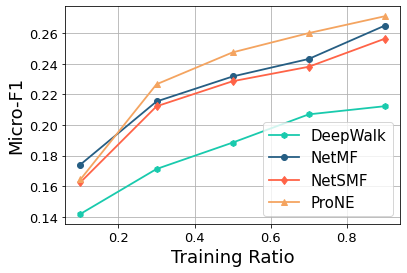

In [8]:
import matplotlib.pyplot as plt

x = training_percents
deepwalk_y = [deepwalk_ret[f"Micro-F1 {s}"] for s in x]
netmf_y = [netmf_ret[f"Micro-F1 {s}"] for s in x]
netsmf_y = [netsmf_ret[f"Micro-F1 {s}"] for s in x]
prone_y = [prone_ret[f"Micro-F1 {s}"] for s in x]

plt.plot(x,deepwalk_y,'h-',color = '#19CAAD',label="DeepWalk",ms=6,lw = 1.8)#s-:方形
plt.plot(x,netmf_y,'o-',color = '#265e83',label="NetMF",ms=6,lw = 1.8)#o-:圆形
plt.plot(x,netsmf_y,'d-',color = '#FF6347',label="NetSMF",ms=6,lw = 1.8)#o-:圆形
plt.plot(x,prone_y,'^-',color = '#F4A460',label="ProNE",ms=6,lw = 1.8)#o-:圆形
plt.xlabel("Training Ratio",fontsize=18)#横坐标名字
plt.ylabel("Micro-F1",fontsize=18)#纵坐标名字
plt.legend(loc = "lower right",fontsize=15)#图例
plt.tick_params(labelsize=13)

plt.grid()
plt.show()

## 5. 实验结果分析

请对实验结果进行分析：结果是否符合你的预期？超参的选择对于最终结果是否有影响？
（可以直接将结果分析写在这里。）